# Initial Setup

In [1]:
from bs4 import Tag, NavigableString, BeautifulSoup
import os
from datetime import datetime
from natsort import os_sorted
import pandas as pd
from IPython.display import display, HTML
import matplotlib as plt
import matplotlib.dates as mdates
import string
from wordcloud import WordCloud, STOPWORDS

In [5]:
# Single file: create a file list sorted by first to last message

folder = "c:/Users/Daniel/Nextcloud/Archive/Facebook Data/messages/inbox/FREENEXTIDE_EbQwaw_iLQ/"
#folder = "c:/Users/Daniel/Documents/Archive/Facebook Data/messages/inbox/GARGBOYZ_uNSTploxvw/"

file_list = []

for filename in os.listdir(folder):
    if filename.endswith('.html'):
       fname = os.path.join(folder, filename)
       file_list.append(fname)

file_list = os_sorted(file_list)
file_list.reverse()
print(file_list)

['c:/Users/Daniel/Nextcloud/Archive/Facebook Data/messages/inbox/FREENEXTIDE_EbQwaw_iLQ/message_18.html', 'c:/Users/Daniel/Nextcloud/Archive/Facebook Data/messages/inbox/FREENEXTIDE_EbQwaw_iLQ/message_17.html', 'c:/Users/Daniel/Nextcloud/Archive/Facebook Data/messages/inbox/FREENEXTIDE_EbQwaw_iLQ/message_16.html', 'c:/Users/Daniel/Nextcloud/Archive/Facebook Data/messages/inbox/FREENEXTIDE_EbQwaw_iLQ/message_15.html', 'c:/Users/Daniel/Nextcloud/Archive/Facebook Data/messages/inbox/FREENEXTIDE_EbQwaw_iLQ/message_14.html', 'c:/Users/Daniel/Nextcloud/Archive/Facebook Data/messages/inbox/FREENEXTIDE_EbQwaw_iLQ/message_13.html', 'c:/Users/Daniel/Nextcloud/Archive/Facebook Data/messages/inbox/FREENEXTIDE_EbQwaw_iLQ/message_12.html', 'c:/Users/Daniel/Nextcloud/Archive/Facebook Data/messages/inbox/FREENEXTIDE_EbQwaw_iLQ/message_11.html', 'c:/Users/Daniel/Nextcloud/Archive/Facebook Data/messages/inbox/FREENEXTIDE_EbQwaw_iLQ/message_10.html', 'c:/Users/Daniel/Nextcloud/Archive/Facebook Data/messa

In [3]:
# Multi-file: Create a file list

folder = "c:/Users/Daniel/Nextcloud/Archive/Facebook Data/messages/inbox/"
#folder = "c:/Users/DANKINAH/Downloads/Personal/Chats/"

file_list = []

for subfolder in os.scandir(folder):
    cur_file_list = []
    for filename in os.listdir(subfolder.path):
        if filename.endswith('.html'):
            fname = os.path.join(subfolder.path, filename)
            cur_file_list.append(fname)
    cur_file_list = os_sorted(cur_file_list)
    cur_file_list.reverse()
    file_list += cur_file_list
display(file_list)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'c:/Users/DANKINAH/Downloads/Personal/Chats/'

In [15]:
members = ['Robby Royston', 'Erik Porteous', 'Nick Cornell', 'Tristan Turigan', 'Daniel Kinahan', 'Alex Staszak', 'Ben Wood', 'Caelan Rae-Oulette', 'Theo Mohamed', 'Francois Jolicoeur']
nickname_strings = ('set the nickname for', 'set your nickname', 'set his own nickname', 'cleared the nickname for', 'cleared your nickname')
group_strings = ('the group.', 'the group photo.', 'set the emoji to', 'named the group')
misc_strings = ('points playing basketball.', 'Plan created:')

In [8]:
# Grab messages from files and place in a sorted list

message_list = []

for filename in file_list:
	with open(filename, encoding='utf-8') as f:
		soup = BeautifulSoup(f, 'html.parser')
	cur_message_list = []
	messages = soup.find_all(class_='pam _3-95 _2pi0 _2lej uiBoxWhite noborder')
	for message in messages[1:]:
		#Types of messages: text with embeds, one or many media items
		sender = message.contents[0].string

		content_text = ""
		content_media = {
			'images':[],
			'videos':[],
			'audio':[],
			'reactions':[]
		}

		if len(message.contents[1].contents[0]) == 4: #Regular message
			for item in message.contents[1].contents[0].contents[1].contents:
				if isinstance(item, Tag):
					if item.name == 'br':
						content_text += '\n'
					elif item.name=='a':
						content_text += item['href']
					elif item.name=='img':
						content_text += item['src']
						content_media['images'].append(item['src'])
					elif item.name=='span': #Arabic text
						content_text += item.string
					else:
						print("Unknown embedded item name: " + item.name)
						exit(1)

				elif isinstance(item, NavigableString):
					content_text += item
				else:
					print("Unknown object type in content: " + str(type(item)))		

		elif len(message.contents[1].contents[0]) > 4: #One or more media
			for item in message.contents[1].contents[0].contents:
				if len(item.contents) > 0:
					if item.find('img'):
						content_media['images'].append(item.find('img')['src'])
					elif item.find('video'):
						content_media['videos'].append(item.find('video')['src'])
					elif item.find('audio'):
						content_media['audio'].append(item.find('audio')['src'])
					elif item.find('ul'):
						for reaction in item.find('ul').contents:
							content_media['reactions'].append(reaction.string)

					elif isinstance(item.string, NavigableString): #attached message
						content_text += item.string
					elif isinstance(item, Tag): #attached message with embeds
						for atom in item.contents:
							if isinstance(atom, Tag):
								if atom.name == 'br':
									content_text += '\n'
								else:
									print("Unknown embedded item name (multi-media): " + str(atom.name))
									print(atom)
									exit(1)
							elif isinstance(atom, NavigableString):
								content_text += atom
							else:
								print("Unknown object type in content (multi-media): " + str(type(atom)))	
					else:
						print("Unknown content item: " + str(type(item)))
						exit(1)

		timestamp = datetime.strptime(str(message.contents[2].string), '%d %b %Y, %H:%M')

		if any(x in content_text for x in nickname_strings):
			message_type = 'nickname'
		elif any(x in content_text for x in group_strings):
			message_type = 'group'
		elif any(x in content_text for x in misc_strings):
			message_type = 'misc'
		else:
			message_type = 'regular'
		
		message_dict = {
			'sender': sender, 
			'content_text':content_text, 
			'content_media':content_media, 
			'timestamp': timestamp,
			'message_type': message_type
		}
		cur_message_list.append(message_dict)

	cur_message_list.reverse()
	message_list += cur_message_list
	print(filename, len(message_list))

c:/Users/Daniel/Nextcloud/Archive/Facebook Data/messages/inbox/FREENEXTIDE_EbQwaw_iLQ/message_18.html 7506
c:/Users/Daniel/Nextcloud/Archive/Facebook Data/messages/inbox/FREENEXTIDE_EbQwaw_iLQ/message_17.html 17506
c:/Users/Daniel/Nextcloud/Archive/Facebook Data/messages/inbox/FREENEXTIDE_EbQwaw_iLQ/message_16.html 27506
c:/Users/Daniel/Nextcloud/Archive/Facebook Data/messages/inbox/FREENEXTIDE_EbQwaw_iLQ/message_15.html 37506
c:/Users/Daniel/Nextcloud/Archive/Facebook Data/messages/inbox/FREENEXTIDE_EbQwaw_iLQ/message_14.html 47506
c:/Users/Daniel/Nextcloud/Archive/Facebook Data/messages/inbox/FREENEXTIDE_EbQwaw_iLQ/message_13.html 57506
c:/Users/Daniel/Nextcloud/Archive/Facebook Data/messages/inbox/FREENEXTIDE_EbQwaw_iLQ/message_12.html 67506
c:/Users/Daniel/Nextcloud/Archive/Facebook Data/messages/inbox/FREENEXTIDE_EbQwaw_iLQ/message_11.html 77506
c:/Users/Daniel/Nextcloud/Archive/Facebook Data/messages/inbox/FREENEXTIDE_EbQwaw_iLQ/message_10.html 87506
c:/Users/Daniel/Nextcloud/Arc

# Individual reports

In [9]:
#Print nicknames for each member

nicknames = dict()

for message_dict in message_list:
	content_text = message_dict['content_text']
	message_type = message_dict['message_type']
	if message_type != 'nickname':
		continue
	if nickname_strings[0] in content_text:
		nickname = content_text.split(nickname_strings[0])[1].split(' to ')[1][:-1]
		name = content_text.split(nickname_strings[0])[1].split(' to ')[0][1:]
	elif nickname_strings[1] in content_text or nickname_strings[2] in content_text:
		nickname = content_text.split('nickname')[1].split(' to ')[1][:-1]
		name = message_dict['sender']

	if name not in nicknames:
		nicknames[name] = []
	else:
		nicknames[name].append(nickname)

print('Nicknames of each member')
for name in nicknames.keys():
    print(name + ": " + ', '.join(nicknames[name]) + "\n")

Nicknames of each member
Tristan Turigan: Cuck, cuck, The happy toker, The wise, Tristan Thomas Turigan, irritated, bro, guy who flirts, Goofball #2, loveball #2, nick, tick, Dane, Dane Adams, Dane Adams, Dane Adams, Dane Adams, Dane Adams, Dane Adams, Dane Adams, Dane Adams, Dane, the grinch who trie, unreliable untrustworthy piece of shit who's late, the cutest one, Yabba doo, trap bastard, the bastard of new orleans, the bastard of orleans, lazy, Watch ljt, The group's real Italian, The group's real baked Italian, The group's real baked Sentinel, Midnight Toker, mohamed, Chicken Chow Mein, Bad Friend 1, Macaque, Mandrill, Mandrill Tariga, dafty, dafty, Xavier, Nick, Cami, Nick, Zolin, Cerberus, Cerberus, Cerberus, Cerberus, Cerberus, Cerberus, Cerberus, Cerberus, slenda triston, tristan-san, rip, rip, rip, rip, rip, rip, rip, rip, Dip, Trip, White Knight Mk7 Gundam, jessica, garmanarnar, garmanarnar, garmanarnar, garmanarnar, garmanarnar, garmanarnar, garmanarnar, garmanarnar, garma

In [10]:
#Print nicknames for each member grouped by day

nicknames = []

for message_dict in message_list:
	content_text = message_dict['content_text']
	message_type = message_dict['message_type']
	if message_type != 'nickname':
		continue
	if nickname_strings[0] in content_text:
		nickname = content_text.split(nickname_strings[0])[1].split(' to ')[1][:-1]
		name = content_text.split(nickname_strings[0])[1].split(' to ')[0][1:]
	elif nickname_strings[1] in content_text or nickname_strings[2] in content_text:
		nickname = content_text.split('nickname')[1].split(' to ')[1][:-1]
		name = message_dict['sender']

	nicknames.append({'name': name, 'nickname': nickname, 'datetime': message_dict['timestamp']})

df = pd.DataFrame(nicknames)
df = df.groupby(df.datetime.dt.date)['nickname'].apply(', '.join).to_frame()

print('Nicknames grouped by day')
display(HTML(df.to_html()))

Nicknames grouped by day


,nickname
datetime,
2016-05-26,The happy toker
2016-05-29,Cuck of the year
2016-05-30,Bernie
2016-06-02,"Cuck, Cuck master, Cuck, Cuck, Cuck, Cuck, Cuck, Cuck lord, Cuck, THE BULL, cuck, cuck, cuck, cuck, cuck, cuck, cuck, the bull, cuck of the year, cuck"
2016-06-03,"yeehaw, the wrangler, Angry little cuck"
2016-06-06,"Angry little cuck, Angry little cuck, Angry little cuck, Angry little cuck, Angry little cuck, Angry little cuck, Angry little cuck, The happy toker, Robby ""Sass Master""Royston"
2016-06-07,"Robby ""Sass Master""Royston"
2016-06-08,"Nick ""Bad Kisser"" Cornell, Robby ""The Bullshitter"" Royston"
2016-06-11,Big fat kike


In [16]:
#Print amount each member has set a nickname

tally = dict()

for message_dict in message_list:
	content_text = message_dict['content_text']
	message_type = message_dict['message_type']
	if message_type != 'nickname':
		continue
	
	name = message_dict['sender']
	if name not in tally:
		tally[name] = 0
	else:
		tally[name] += 1

tally = sorted(tally.items(), key=lambda x:x[1], reverse=True)
print('Amount each member has set or cleared a nickname')
display(tally)

Amount each member has set or cleared a nickname


[('Robby Royston', 207),
 ('Ben Wood', 180),
 ('Daniel Kinahan', 172),
 ('Alex Staszak', 153),
 ('Caelan Rae-Oulette', 82),
 ('Nick Cornell', 59),
 ('Erik Porteous', 32),
 ('Tristan Turigan', 30),
 ('Theo Mohamed', 8),
 ('Brye Loelke', 6),
 ('Francois Jolicoeur', 2)]

In [17]:
#Print amount each member has said a certain word

#Make sure no string is a substring of another in this list
keys = ['friend']

tally = dict.fromkeys(members, 0)

for message_dict in message_list:
	content_text = message_dict['content_text'].casefold()
	message_type = message_dict['message_type']
	num = 0
	
	if not content_text or message_type != 'regular':
		continue
	for key in keys:
		num += content_text.count(key)

	name = message_dict['sender']
	if name not in members:
		tally[name] = num
	else:
		tally[name] += num

tally = sorted(tally.items(), key=lambda x:x[1], reverse=True)
print('Word frequency of: ' + str(keys))
display(tally)

Word frequency of: ['friend']


[('Robby Royston', 150),
 ('Ben Wood', 109),
 ('Caelan Rae-Oulette', 107),
 ('Daniel Kinahan', 104),
 ('Alex Staszak', 86),
 ('Nick Cornell', 68),
 ('Tristan Turigan', 41),
 ('Erik Porteous', 27),
 ('Theo Mohamed', 9),
 ('Francois Jolicoeur', 0),
 ('Brye Loelke', 0),
 ('Facebook User', 0)]

In [19]:
#Print amount each word has been said

extra = {'u', 'im', 'dont', 'yea', 'thats', 'yeah', 'ill', 'oh', 'got', 'ur', 'tho', 'actually'}
stopwords = set(STOPWORDS) | extra

words = dict()

for message_dict in message_list:
	content_text = message_dict['content_text'].translate(str.maketrans('', '', string.punctuation)).casefold()
	message_type = message_dict['message_type']
	if not content_text or message_type != 'regular':
		continue

	for word in content_text.split():
		if word not in stopwords:
			if word not in words:
				words[word] = 0
			words[word] += 1

words = sorted(words.items(), key=lambda x:x[1], reverse=True)
print('Word frequencies')
display(words)

Word frequencies


[('lol', 10410),
 ('one', 3521),
 ('think', 3213),
 ('good', 3130),
 ('go', 2917),
 ('come', 2750),
 ('guys', 2532),
 ('shit', 2478),
 ('really', 2346),
 ('nice', 2313),
 ('nick', 2216),
 ('pretty', 2102),
 ('alex', 2010),
 ('gonna', 1927),
 ('ben', 1893),
 ('now', 1840),
 ('know', 1839),
 ('want', 1801),
 ('wanna', 1800),
 ('erik', 1766),
 ('robby', 1759),
 ('time', 1688),
 ('dude', 1562),
 ('it’s', 1557),
 ('much', 1508),
 ('idk', 1506),
 ('say', 1478),
 ('maybe', 1476),
 ('id', 1472),
 ('going', 1399),
 ('man', 1363),
 ('even', 1359),
 ('rob', 1326),
 ('back', 1324),
 ('i’m', 1304),
 ('work', 1278),
 ('fuck', 1267),
 ('probably', 1266),
 ('boys', 1259),
 ('kinda', 1258),
 ('tristan', 1226),
 ('car', 1224),
 ('cant', 1212),
 ('caelan', 1200),
 ('still', 1192),
 ('will', 1183),
 ('way', 1177),
 ('see', 1175),
 ('people', 1154),
 ('need', 1148),
 ('bad', 1137),
 ('daniel', 1122),
 ('night', 1113),
 ('make', 1106),
 ('cool', 1106),
 ('new', 1101),
 ('didnt', 1100),
 ('sure', 1097),
 ('s

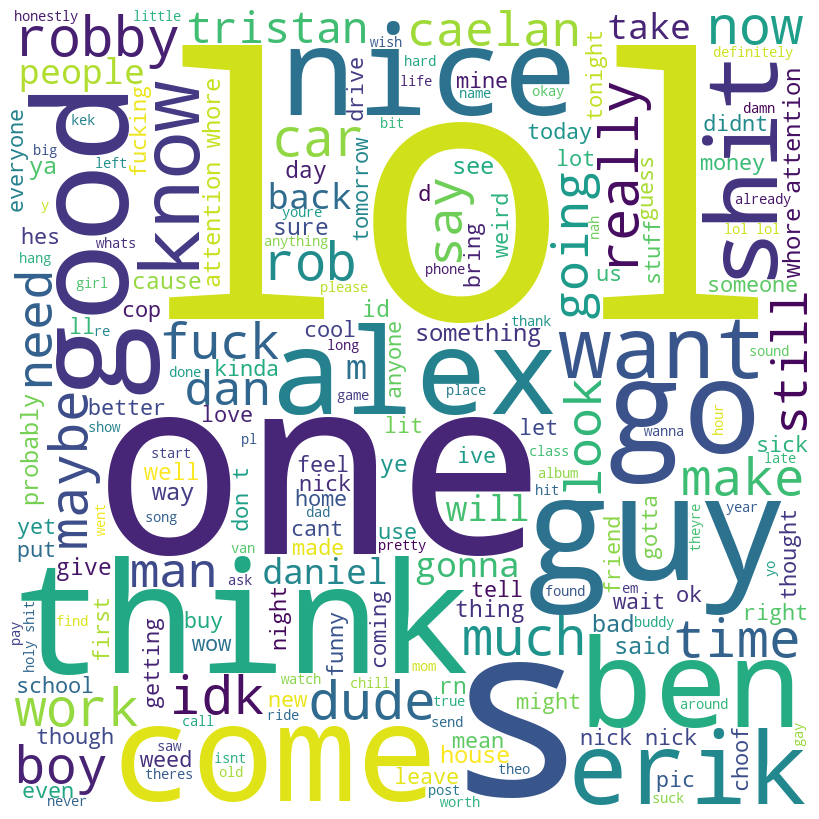

In [21]:
#Print wordcloud
words = dict()
comment_words = ''
extra = {'u', 'im', 'dont', 'yea', 'thats', 'yeah', 'ill', 'oh', 'got', 'ur', 'tho', 'actually'}
stopwords = set(STOPWORDS) | extra

for message_dict in message_list:
	content_text = message_dict['content_text'].translate(str.maketrans('', '', string.punctuation)).casefold()
	message_type = message_dict['message_type']
	if not content_text or message_type != 'regular':
		continue

	comment_words += content_text + " "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.pyplot.figure(figsize = (8, 8), facecolor = None)
plt.pyplot.imshow(wordcloud, interpolation="bilinear")
plt.pyplot.axis("off")
plt.pyplot.tight_layout(pad = 0)
 
plt.pyplot.show()

In [22]:
# Print kickee and kicker amounts for each guy

kickers = dict()
kickees = dict()

for message_dict in message_list:
	content_text = message_dict['content_text']
	name = message_dict['sender']
	if message_dict['message_type'] != 'group':
		continue
	if 'removed' in content_text:
		#Crystal cowboy removed Nick Cornell from the group.
		if name not in kickers:
			kickers[name] = 1
		else:
			kickers[name] += 1

		kickee = content_text.split(' removed ')[1].replace(' from the group.', '')
		if kickee == 'you':
			kickee = 'Daniel Kinahan'

		if kickee not in kickees:
			kickees[kickee] = 1
		else:
			kickees[kickee] += 1

        
kickers = sorted(kickers.items(), key=lambda x:x[1], reverse=True)
kickees = sorted(kickees.items(), key=lambda x:x[1], reverse=True)

print('Kickers')
display(kickers)

print('Kickees')
display(kickees)

Kickers


[('Daniel Kinahan', 61),
 ('Ben Wood', 57),
 ('Caelan Rae-Oulette', 49),
 ('Alex Staszak', 25),
 ('Tristan Turigan', 23),
 ('Robby Royston', 22),
 ('Nick Cornell', 14),
 ('Theo Mohamed', 4),
 ('Erik Porteous', 2)]

Kickees


[('Daniel Kinahan', 44),
 ('Alex Staszak', 41),
 ('Robby Royston', 41),
 ('Nick Cornell', 35),
 ('Ben Wood', 22),
 ('Erik Porteous', 21),
 ('Caelan Rae-Oulette', 19),
 ('Tristan Turigan', 13),
 ('a participant', 4),
 ('Brye Loelke', 4),
 ('Alex Wilson', 2),
 ('Adrian Aucoin', 2),
 ('Slenda Maan', 1),
 ('Haley McCoy', 1),
 ('David Wood', 1),
 ('Egg Timer', 1),
 ('Axon Adrian Ogayon', 1),
 ('Tristan Tarigan', 1),
 ('SlenderWo Man', 1),
 ('Theo Mohamed', 1),
 ('Rose de Roos', 1)]

In [23]:
# Print unique kick connections

kicks = dict()

for message_dict in message_list:
	content_text = message_dict['content_text']
	name = message_dict['sender']
	if message_dict['message_type'] != 'group':
		continue
	if 'removed' in content_text:
		#Crystal cowboy removed Nick Cornell from the group.

		kickee = content_text.split(' removed ')[1].replace(' from the group.', '')
		if kickee == 'you':
			kickee = 'Daniel Kinahan'

		kick = name + " removed " + kickee
		if kick in kicks:
			kicks[kick] += 1
		else:
			kicks[kick] = 1

        
kicks = sorted(kicks.items(), key=lambda x:x[1], reverse=True)

print('Kicks')
display(kicks)

Kicks


[('Ben Wood removed Alex Staszak', 15),
 ('Ben Wood removed Robby Royston', 15),
 ('Daniel Kinahan removed Nick Cornell', 13),
 ('Alex Staszak removed Robby Royston', 9),
 ('Ben Wood removed Daniel Kinahan', 9),
 ('Caelan Rae-Oulette removed Robby Royston', 9),
 ('Tristan Turigan removed Daniel Kinahan', 9),
 ('Caelan Rae-Oulette removed Nick Cornell', 9),
 ('Daniel Kinahan removed Alex Staszak', 8),
 ('Daniel Kinahan removed Ben Wood', 8),
 ('Caelan Rae-Oulette removed Alex Staszak', 8),
 ('Caelan Rae-Oulette removed Daniel Kinahan', 7),
 ('Daniel Kinahan removed Robby Royston', 6),
 ('Alex Staszak removed Daniel Kinahan', 6),
 ('Caelan Rae-Oulette removed Erik Porteous', 6),
 ('Ben Wood removed Caelan Rae-Oulette', 6),
 ('Robby Royston removed Daniel Kinahan', 6),
 ('Ben Wood removed Nick Cornell', 5),
 ('Daniel Kinahan removed Caelan Rae-Oulette', 5),
 ('Robby Royston removed Alex Staszak', 5),
 ('Daniel Kinahan removed Tristan Turigan', 4),
 ('Ben Wood removed Tristan Turigan', 4),

In [24]:
message_count = dict()

for message_dict in message_list:
    name = message_dict['sender']
    if name not in message_count:
        message_count[name] = 0
    message_count[name] += 1

message_count = sorted(message_count.items(), key=lambda x:x[1], reverse=True)

print('Message count:')
display(message_count)

Message count:


[('Robby Royston', 29684),
 ('Caelan Rae-Oulette', 27104),
 ('Alex Staszak', 26643),
 ('Ben Wood', 23559),
 ('Daniel Kinahan', 22308),
 ('Nick Cornell', 16808),
 ('Tristan Turigan', 13213),
 ('Erik Porteous', 10321),
 ('Theo Mohamed', 7425),
 ('Brye Loelke', 368),
 ('Francois Jolicoeur', 62),
 ('Caislin Rae', 1),
 ('Alex Wilson', 1),
 ('Savage Young', 1),
 ('Jacarri Davis', 1),
 ('Michał Ziemak', 1),
 ('Facebook User', 1),
 ('Santa Jar', 1),
 ('Robert Ristin', 1),
 ('Rob Ruston', 1),
 ('Nick Kornely', 1),
 ('Steve Labrie', 1)]

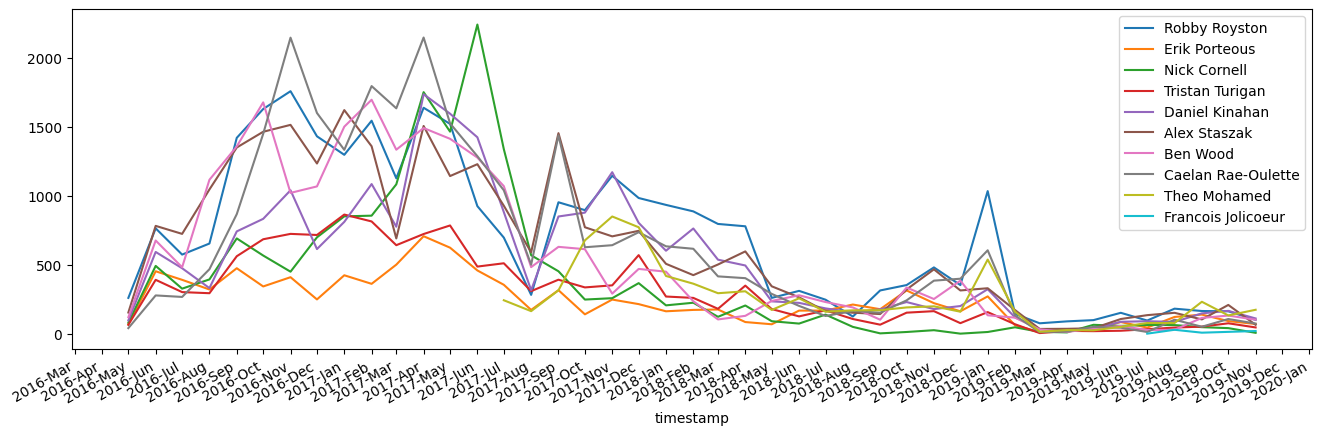

In [25]:
#Print message frequency over time per person

plt.rcParams["figure.figsize"] = (16,5)

df = pd.DataFrame(message_list)
# df.groupby([df.datetime.dt.year, df.datetime.dt.month])['sender'].count().plot()

members = ['Robby Royston', 'Erik Porteous', 'Nick Cornell', 'Tristan Turigan', 'Daniel Kinahan', 'Alex Staszak', 'Ben Wood', 'Caelan Rae-Oulette', 'Theo Mohamed', 'Francois Jolicoeur']
for member in members:
    temp=df[df['sender']==member]
    ax = temp.groupby(df.timestamp.dt.to_period('M'))['sender'].count().plot(x_compat=True)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax.legend(members)